### Python bot for Uniswap trading

In [ ]:
%pip install web3
%pip install uniswap-python

In [2]:
import math
import time
import pytz
import secrets
import requests
import numpy as np
import credentials
from web3 import Web3
from uniswap import Uniswap
from datetime import datetime
from eth_account import Account
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [3]:
#Connect to Ethereum

#RPC endpoints

INFURA_KEY = credentials.infura_key
ETHERSCAN_KEY = credentials.etherscan_key
QUICKNODE_KEY = credentials.quicknode_key

RPC = {
    'mainnet': f'https://mainnet.infura.io/v3/{INFURA_KEY}',
    'goreli': f'https://goerli.infura.io/v3/{INFURA_KEY}',
    'mainnet_ws': f'wss://mainnet.infura.io/ws/v3/{INFURA_KEY}',
    'goreli_ws': f'wss://goerli.infura.io/ws/v3/{INFURA_KEY}',
    'quicknode': f'https://wider-weathered-theorem.discover.quiknode.pro/{QUICKNODE_KEY}/',
    'quicknode_ws': f'wss://wider-weathered-theorem.discover.quiknode.pro/{QUICKNODE_KEY}/',
}

#Connect to Ethereum mainnet
mainnet_ws = RPC['quicknode_ws']
w3 = Web3(Web3.WebsocketProvider(mainnet_ws))
w3.is_connected()

True

In [4]:
def initialize_wallet(option):
    if option == 1:
        #Get a new wallet to trade with
        prive_key = secrets.token_hex(32)
        account = Account.from_key(prive_key)
        account_info = {
            "account": account,
            "private_key": prive_key,
            "address": account.address
        }
        return account_info
    elif option == 2:
        #Import wallet with funds
        prive_key_imported = input("Enter your private key: ")
        account_imported = Account.from_key(prive_key_imported)
        account_info = {
            "account": account_imported,
            "private_key": prive_key_imported,
            "address": account_imported.address
        }
        return account_info
    print("Invalid option")
    return None

In [5]:
def get_abi(contract_address):
    #Get Contract ABI with Etherscan API
    api_key = ETHERSCAN_KEY
    url = 'https://api.etherscan.io/api'
    params = {
        'module': 'contract',
        'action': 'getabi',
        'address': contract_address,
        'apikey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    if data['status'] != '1':
        print("Error: ", data['message'])
        return None
    else:
        abi = data['result']
        return abi

def get_token_info(token_address):
        abi = get_abi(token_address)
        #Initialize contract
        contract = w3.eth.contract(address=token_address, abi=abi)
        #Get token info
        totalsupply, decimals, symbol, owner = None, None, None, None
        try:
            totalsupply = contract.functions.totalSupply().call()
            decimals = contract.functions.decimals().call()
            symbol = contract.functions.symbol().call()
            owner = contract.functions.owner().call()
        except:
            pass
        token_info = {
            "totalsupply": totalsupply,
            "decimals": decimals,
            "symbol": symbol,
            "owner": owner
        }
        return token_info

### Method 1: Using Uniswap SDK python wrapper

In [5]:
#Initialize Uniswap Object
account_info = initialize_wallet(1)

address = account_info['address']
private_key = account_info['private_key']
version = 2
provider = RPC['mainnet']

uniswap_v2 = Uniswap(address=address, private_key=private_key, version=version, provider=provider)

version = 3
uniswap_v3 = Uniswap(address=address, private_key=private_key, version=version, provider=provider)

In [6]:
def conversion(rate_1, rate_2, decimal_1, decimal_2):
    conversion = ((1 / rate_1) * (rate_2 / 10 ** decimal_2)) * 10 ** decimal_1
    return conversion

In [ ]:
#Token info
weth = Web3.to_checksum_address("0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2")
usdt = Web3.to_checksum_address("0xdac17f958d2ee523a2206206994597c13d831ec7")
usdc = Web3.to_checksum_address("0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48")
addr = Web3.to_checksum_address("0xfb66321d7c674995dfcc2cb67a30bc978dc862ad")
token_info = get_token_info(addr)
print(token_info)

#Search for token pair in Uniswap v2
try:
    print("V2:")
    print(f"Sell price")
    token_rate = uniswap_v2.get_price_input(weth, addr, qty=10 ** 18)
    print(f"1 ETH = {conversion(1, token_rate, 18, token_info['decimals'])} {token_info['symbol']}")

    print(f"Buy price")
    token_rate = uniswap_v2.get_price_output(addr, weth, qty=10 ** 18)
    print(f"1 ETH = {conversion(1, token_rate, 18, token_info['decimals'])} {token_info['symbol']}")
    
except Exception as error:
    print(error)

# #Search for token pair in Uniswap v3
# try:
#     token_rate = uniswap_v3.get_price_input(weth, addr, qty=10 ** 18)
#     print("V3:")
#     print(f"1 {token_info['symbol']} = {conversion(token_rate, usdt_rate, token_info['decimals'], 6)} USDT")
#     print(f"1 ETH = {conversion(1, token_rate, 0, token_info['decimals'])} {token_info['symbol']}")
# except Exception as error:
#     print(error)

### Method 2: Using Query the blockchain directly

In [9]:
#Uniswap V2, token pair address
UNISWAP_V2_FACTORY = Web3.to_checksum_address("0x5C69bEe701ef814a2B6a3EDD4B1652CB9cc5aA6f")

USDT = Web3.to_checksum_address("0xdac17f958d2ee523a2206206994597c13d831ec7")
USDC = Web3.to_checksum_address("0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48")
WETH = Web3.to_checksum_address("0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2")
WBTC= Web3.to_checksum_address("0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599")
PEPE = Web3.to_checksum_address("0x6982508145454Ce325dDbE47a25d4ec3d2311933")

TOKEN_0 = Web3.to_checksum_address("0xfb66321d7c674995dfcc2cb67a30bc978dc862ad")
TOKEN_1 = WETH

#Get token info
token_0_info = get_token_info(TOKEN_0)
token_1_info = get_token_info(TOKEN_1)
#Get token decimals
token_0_decimals = token_0_info['decimals']
token_1_decimals = token_1_info['decimals']
#Get token symbol
token_0_symbol = token_0_info['symbol']
token_1_symbol = token_1_info['symbol']

#Get Uniswap V2 Factory Contract ABI
abi_v2 = get_abi(UNISWAP_V2_FACTORY)
#Initialize contract
contract_v2 = w3.eth.contract(address=UNISWAP_V2_FACTORY, abi=abi_v2)
#Get token pair address
pair_address = contract_v2.functions.getPair(TOKEN_0, TOKEN_1).call()
print(f"Pair address: {pair_address}")

if w3.to_int(hexstr=pair_address) == 0:
    print("Pair not found")
    raise

#Calculate token price using getReserves() function
abi_pair = get_abi(pair_address)
contract_pair = w3.eth.contract(address=pair_address, abi=abi_pair)
reserve = contract_pair.functions.getReserves().call()

#Caculate token pair rate
if TOKEN_0 < TOKEN_1:
    token_0_reserve = reserve[0]/10**token_0_decimals
    token_1_reserve = reserve[1]/10**token_1_decimals
    print("1")
else:
    token_0_reserve = reserve[1]/10**token_0_decimals
    token_1_reserve = reserve[0]/10**token_1_decimals
    print("2")
token_pair_rate = token_0_reserve/token_1_reserve

print(f"Token 0 ({token_0_symbol}) reserve: {token_0_reserve}")
print(f"Token 1 ({token_1_symbol}) reserve: {token_1_reserve}")
print(f"Block timestamp last: {reserve[2]}\n")

#Raw token rate
print(f"Raw token price: 1 token_1 = {token_pair_rate} token_0")

#AmountIn rate
if TOKEN_1<TOKEN_0:
    reserveOut = reserve[1]/10**token_0_decimals
    reserveIn = reserve[0]/10**token_1_decimals #Base token
else:
    reserveOut = reserve[0]/10**token_0_decimals
    reserveIn = reserve[1]/10**token_1_decimals #Base token

amountIn = 1 #1 WETH
amountIn = amountIn * 997/1000 #fee 0.3%
amountOut = amountIn*reserveOut/(reserveIn+amountIn)
print(f"True token price: Max amount (out) given 1 token_1 in: {amountOut}")

#AmountOut rate
if TOKEN_1<TOKEN_0:
    reserveIn = reserve[1]/10**token_0_decimals
    reserveOut = reserve[0]/10**token_1_decimals #Base token
else:
    reserveIn = reserve[0]/10**token_0_decimals
    reserveOut = reserve[1]/10**token_1_decimals #Base token

amountOut = 1 #1 WETH
amountOut = amountOut * 1000/997 #fee 0.3%
amountIn = amountOut * reserveIn / (reserveOut - amountOut)
print(f"True token price: Min amount (in) given 1 token_1 out:  {amountIn}")

Pair address: 0x076a3e1500f3110D8F4445D396A3d7cA6D0Ca269
2
Token 0 (PEPE2.0) reserve: 11111475785059.584
Token 1 (WETH) reserve: 409.8127890641788
Block timestamp last: 1689352355

Raw token price: 1 token_1 = 27113540820.51224 token_0
True token price: Max amount (out) given 1 token_1 in: 26966595374.809143
True token price: Min amount (in) given 1 token_1 out:  27261849057.52026


### Query multiple uniswap pairs (routing)

In [10]:
#path = [token_0, token_1, token_2, ..., token_n]
#Swap token_0 -> token_1,  Swap token_1 -> token_2, ..., Swap token_n-1 -> token_n
def pathFinder(token_0, token_1):
    path = [token_0]
    #check if token_0 and token_1 pair exist
    pair_address = contract_v2.functions.getPair(token_0, token_1).call()
    if w3.to_int(hexstr=pair_address) != 0:
        path.append(token_1)
        return path #return direct path
    else:
        #if path does not exist, try pairing it with WETH
        pair_address0 = contract_v2.functions.getPair(token_0, WETH).call()
        pair_address1 = contract_v2.functions.getPair(token_1, WETH).call()
        if w3.to_int(hexstr=pair_address0) != 0 and w3.to_int(hexstr=pair_address1) != 0:
            path.append(WETH)
            path.append(token_1)
            return path
        else:
            return None

#Given x token_0 in find max amount of token_1 out
def AmountIn(token_0, token_1, amountIn):
    #get token pair address
    pair_address = contract_v2.functions.getPair(token_0, token_1).call()
    if w3.to_int(hexstr=pair_address) != 0:
        #get reserve
        abi_pair = get_abi(pair_address)
        contract_pair = w3.eth.contract(address=pair_address, abi=abi_pair)
        reserve = contract_pair.functions.getReserves().call()
        #get token info
        token_0_info = get_token_info(token_0)
        token_1_info = get_token_info(token_1)
        #get token decimals
        token_0_decimals = token_0_info['decimals']
        token_1_decimals = token_1_info['decimals']
        #caculate amountIn
        if token_0 < token_1: #token_0 = token in, token_1 = token out
            reserveIn = reserve[0]/10**token_0_decimals
            reserveOut = reserve[1]/10**token_1_decimals
        else:
            reserveIn = reserve[1]/10**token_0_decimals
            reserveOut = reserve[0]/10**token_1_decimals

        amountIn = amountIn * 997/1000 #fee 0.3%
        amountOut = amountIn*reserveOut/(reserveIn+amountIn)
        return amountOut
    else:
        return None

#Give x token_0 out find min amount of token_1 in
def AmountOut(token_0, token_1, amountOut):
    pair_address = contract_v2.functions.getPair(token_0, token_1).call()
    if w3.to_int(hexstr=pair_address) != 0:
        abi_pair = get_abi(pair_address)
        contract_pair = w3.eth.contract(address=pair_address, abi=abi_pair)
        reserve = contract_pair.functions.getReserves().call()
        token_0_info = get_token_info(token_0)
        token_1_info = get_token_info(token_1)
        token_0_decimals = token_0_info['decimals']
        token_1_decimals = token_1_info['decimals']
        if token_0 < token_1: #token_0 = token out, token_1 = token in
            reserveOut = reserve[0]/10**token_0_decimals
            reserveIn = reserve[1]/10**token_1_decimals
        else:
            reserveOut = reserve[1]/10**token_0_decimals
            reserveIn = reserve[0]/10**token_1_decimals
        amountOut = amountOut * 1000/997 #fee 0.3%
        amountIn = amountOut * reserveIn / (reserveOut - amountOut)
        return amountIn
    else:
        return None

# Chained amountIn
def chainedAmountIn(token_0, token_1, amountIn):
    path = pathFinder(token_0, token_1)
    amount = [amountIn]
    if path != None:
        for i in range(len(path)-1):
            amount.append(AmountIn(path[i], path[i+1], amount[i]))
        return amount
    else:
        return None

# Chained amountOut
def chainedAmountOut(token_0, token_1, amountOut):
    path = pathFinder(token_0, token_1)
    amount = [amountOut]
    if path != None:
        for i in range(len(path)-1):
            amount.append(AmountOut(path[i], path[i+1], amount[i]))
        return amount
    else:
        return None
    
# print(chainedAmountIn(USDT, PEPE, 1))
print(chainedAmountOut(USDT, PEPE, 1))

#Caculate the cumulative price using priceCumulativeLast() function
# token_0_price_cumulative_last = contract_pair.functions.price0CumulativeLast().call()
# token_1_price_cumulative_last = contract_pair.functions.price1CumulativeLast().call()

[1, 0.0005047201450702597, 568460.3772568515]


### Token Monitor mode

Token 0 (PEPE2.0) reserve: 11109460046121.273
Token 1 (WETH) reserve: 411.0876036569386
Raw token rate:
1 WETH = 27024556195.06434 Token


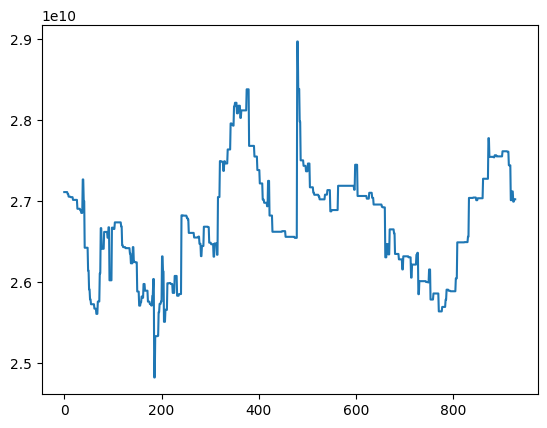

KeyboardInterrupt: 

In [11]:
price_chart = []
time_chart = []
refresh = int(input("Enter the refresh time in seconds: "))
while True:
    reserve = contract_pair.functions.getReserves().call()

    if TOKEN_1 < TOKEN_0:
        token_0_reserve = reserve[1]/10**token_0_decimals
        token_1_reserve = reserve[0]/10**token_1_decimals 
        token_pair_rate = token_0_reserve/token_1_reserve
    else:
        token_0_reserve = reserve[0]/10**token_0_decimals
        token_1_reserve = reserve[1]/10**token_1_decimals
        token_pair_rate = token_0_reserve/token_1_reserve

    price_chart.append(token_pair_rate)
    current_time_est = datetime.now(pytz.timezone("America/New_York")).strftime("%m-%d %H:%M:%S")
    time_chart.append(current_time_est)
    
    clear_output(wait=True)
    print(f"Token 0 ({token_0_symbol}) reserve: {token_0_reserve}")
    print(f"Token 1 ({token_1_symbol}) reserve: {token_1_reserve}")

    #Raw token rate
    print("Raw token rate:")
    print("1 WETH =", token_pair_rate, "Token")

    plt.plot(time_chart, price_chart, color='blue', marker='o', linestyle='-', markerfacecolor='red')
    plt.xlabel('Time')
    plt.ylabel(f'Rate')
    plt.title('Token Pair Rate')
    plt.grid(True)
    plt.show()
    
    time.sleep(refresh)

### Supply Monitor mode

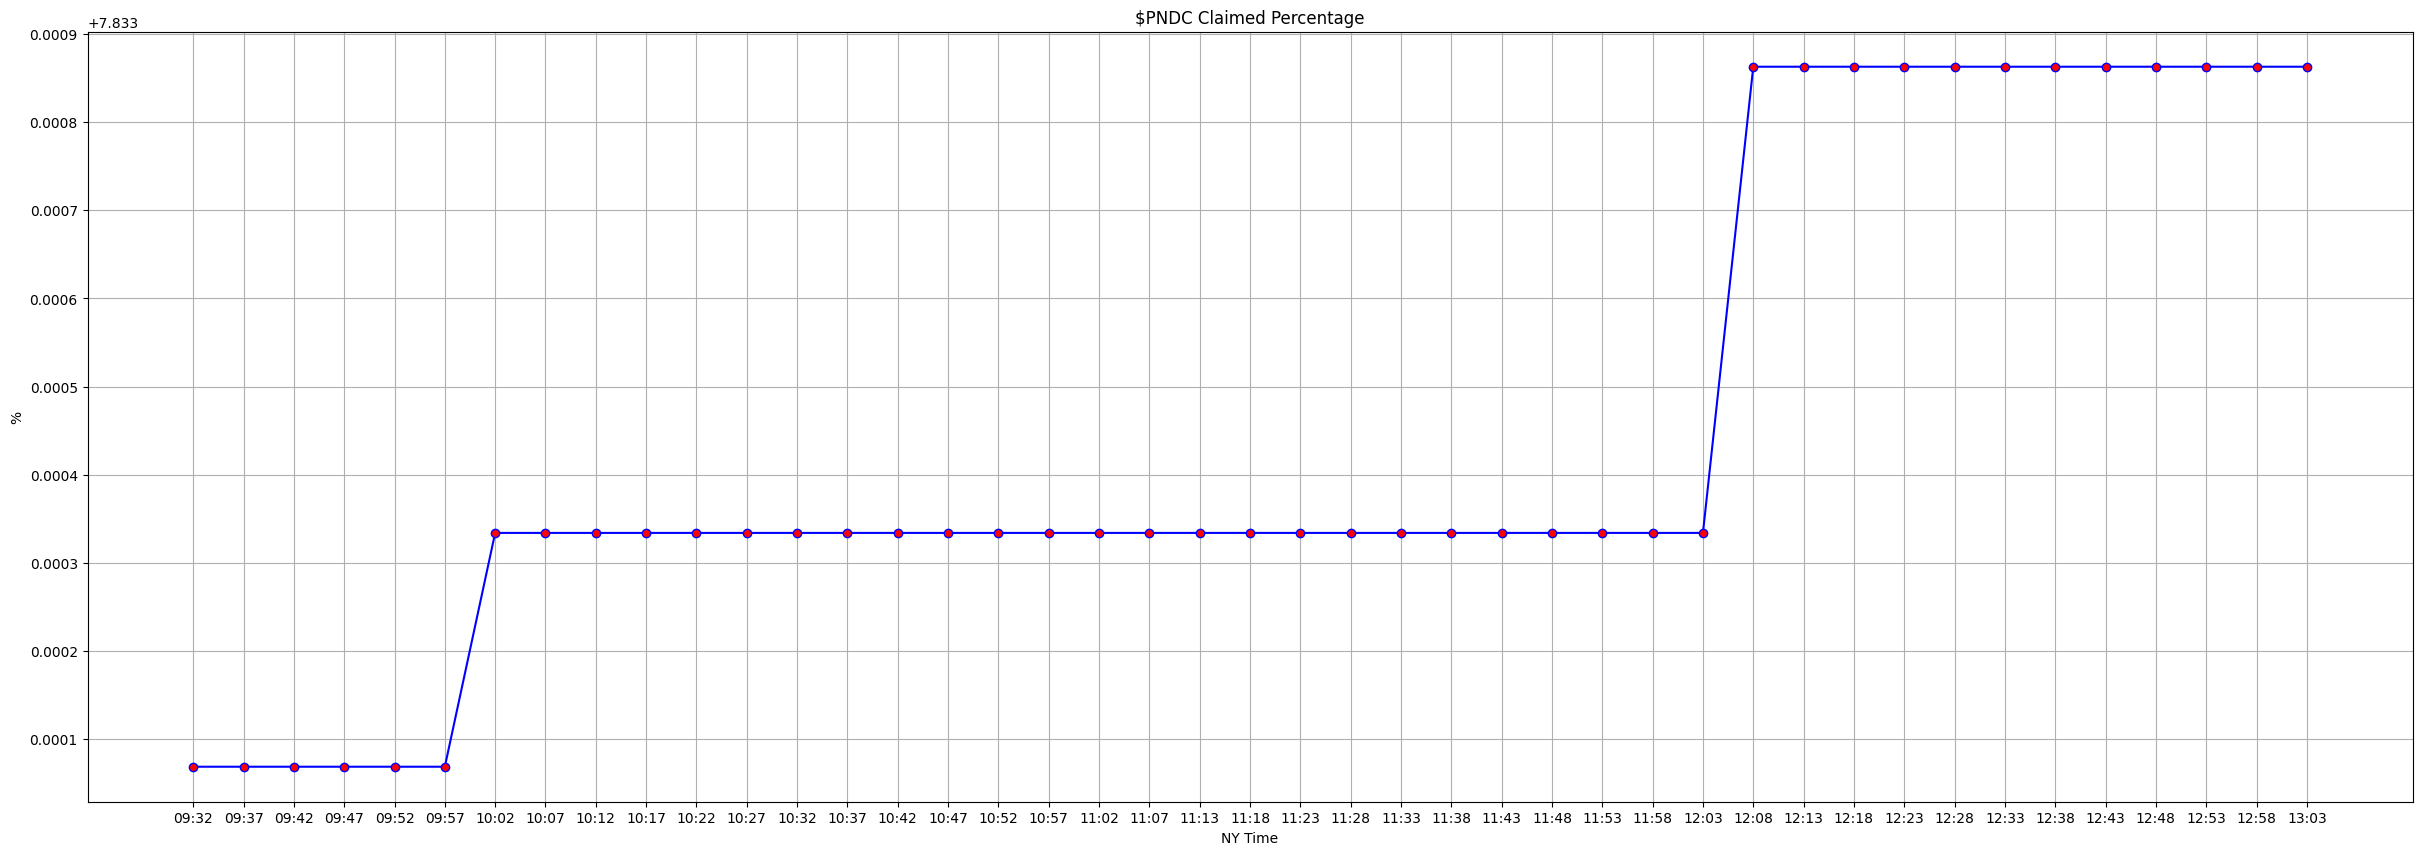

In [6]:
change = []
time_chage = []
refresh = 300
addr = Web3.to_checksum_address("0x423f4e6138E475D85CF7Ea071AC92097Ed631eea")
token_info = get_token_info(addr)
maxSupply = 420689000000000000000000000000000

# print("Supply out:", token_info["totalsupply"] / maxSupply * 100, "%")
while True:
    try:
        clear_output(wait=True)
        token_info = get_token_info(addr)
        current_time_est = datetime.now(pytz.timezone("America/New_York")).strftime("%H:%M")
        change.append(token_info["totalsupply"] / maxSupply * 100)
        time_chage.append(current_time_est)
    except:
        continue
    
    plt.figure(figsize=(30, 10))
    plt.plot(time_chage, change, color='blue', marker='o', linestyle='-', markerfacecolor='red')
    plt.xlabel('NY Time')
    plt.ylabel('%')
    plt.title('$PNDC Claimed Percentage')
    plt.grid(True)
    plt.show()

    time.sleep(refresh)

### Uniswap Fundamentals

In [ ]:
#Swap function simulator (neglect address to and bytes calldata data)

#Assumption
reserve0 = 1000   #Token
reserve1 = 2000     #WETH

amount0Out = 0      #Token
amount1Out = 200    #WETH

amount0sent = 100   #Token

#Call swap fuction
if amount0Out == 0 and amount1Out == 0:
    print("Invalid amount (Zero swap)")
    raise
if amount0Out > reserve0 or amount1Out > reserve1:
    print("Insufficient liquidity")
    raise
if amount0Out > 0:
    print(f'Sent {amount0Out} to swaper')
if amount1Out > 0:
    print(f'Sent {amount1Out} to swaper')

#After swap checking balance on ERC20 token contract balanceOF(address) function
balance0 = reserve0 + amount0sent
balance1 = reserve1 - amount1Out
print(f"Balance0: {balance0}, Balance1: {balance1}")

#Calculate the amount of token to be received to the contract
if balance0 > reserve0 - amount0Out:
    amount0In = balance0 - (reserve0 - amount0Out)
else:
    amount0In = 0

if balance1 > reserve1 - amount1Out:
    amount1In = balance1 - (reserve1 - amount1Out)
else:
    amount1In = 0

print(f"Amount0In: {amount0In}, Amount1In: {amount1In}")

if amount0In <= 0 and amount1In <= 0:
    print("Not enough input amount")
    raise

balance0Adjusted = balance0 * 1000 - amount0In * 3 #fee 0.3%
balance1Adjusted = balance1 * 1000 - amount1In * 3 #fee 0.3%
print(f"Balance0Adjusted: {balance0Adjusted}, Balance1Adjusted: {balance1Adjusted}")

if balance0Adjusted * balance1Adjusted <= reserve0 * reserve1 * 1000 ** 2:
    print("Price impact too high")
    raise

In [13]:
#x * y = k
#reserveIn * reserveOut = (reserveIn + amountIn) * (reserveOut - amountOut)

#Get amount out simuator (Given amountIn calculate max amountOut)
reserveIn = 100 #WETH 1 WETH = 100 USDT
reserveOut = 10000  #USDT
amountIn = 1 #WETH
amountIn = amountIn * 997/1000 #fee 0.3%
amountOut = amountIn*reserveOut/(reserveIn+amountIn)
print(f"Max AmountOut: {amountOut}")

#Get amount in simuator (Given amountOut calculate min amountIn)
reserveIn = 10000 #USDT
reserveOut = 100  #WETH 1 WETH = 100 USDT
amountOut = 1 #WETH
amountOut = amountOut * 1000/997 #fee 0.3%
amountIn = amountOut * reserveIn / (reserveOut - amountOut)
print(f"Min AmountIn: {amountIn}")

Max AmountOut: 98.71580343970614
Min AmountIn: 101.31712259371835


In [14]:
#constant product formula
# x * y = k
#Assume initial liquidity of 100000DAI and 1000WETH
#Our share is 10000DAI and 100WETH (10%)
x = 100000
y = 1000
k = x * y
print("before")
print("The LP has", x, "DAI and", y, "WETH")
print("price of 1 DAI =", y/x, "WETH")
print("price of 1 WETH =", x/y, "DAI")

#Now assume that the price of ETH increases to 150DAI

#find new x and y such that x/y = 150 and x * y = k

y = math.sqrt(k / 150)
x = math.sqrt(k * 150)
print("after")
print("The LP has", x, "DAI and", y, "WETH")
print("price of 1 DAI =", y/x, "WETH")
print("price of 1 WETH =", x/y, "DAI")

#Find the impermanent loss

hold_value = 10000 + 100 * 150
print("Hold value =", hold_value, "DAI")
LP_share_value = x*0.1 + y*0.1*150
print("LP share value =", LP_share_value, "DAI")
impermanent_loss = LP_share_value - hold_value
print("Impermanent loss =", impermanent_loss, "DAI", impermanent_loss/hold_value*100,"%")


before
The LP has 100000 DAI and 1000 WETH
price of 1 DAI = 0.01 WETH
price of 1 WETH = 100.0 DAI
after
The LP has 122474.48713915891 DAI and 816.496580927726 WETH
price of 1 DAI = 0.006666666666666666 WETH
price of 1 WETH = 150.00000000000003 DAI
Hold value = 25000 DAI
LP share value = 24494.897427831784 DAI
Impermanent loss = -505.1025721682163 DAI -2.020410288672865 %
